A simple example illustrating how to generate a mesh, construct a fractional SPDE model, estimate parameters and make a prediction.

In [1]:
import enum
import os
import sys

import copy
import pickle
from dataclasses import asdict
from typing import List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from spde.mesh import Mesh
from spde.model import SPDEModel
from spde.optimization import optimize_parameters

from utils.scores import coverage, crps, rmse
from utils.scipy_torch_conversion import torch_coo_to_scipy_csc


## Construct mesh

Mesh loaded with 7482 vertices


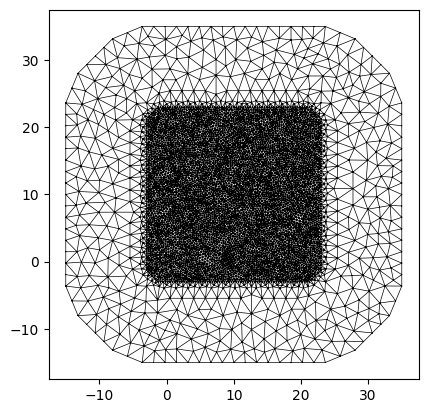

In [2]:
mesh_filename = "mesh.pkl"
if os.path.exists(mesh_filename):
    with open(mesh_filename, "rb") as f:
        mesh = pickle.load(f)
else:
    min_x = 0
    max_x = 20
    min_y = 0
    max_y = 20
    loc_domain = torch.tensor(
        [[min_x, min_y], [max_x, min_y], [max_x, max_y], [min_x, max_y], [min_x, min_y]]
    )

    max_edge_inner = 0.5
    mesh = Mesh()
    cutoff = np.array([max_edge_inner / 5])
    offset = np.array([3, 15 - 3])
    max_edge = np.array([max_edge_inner, 6 * max_edge_inner])
    mesh.create_mesh(
        max_edge=max_edge, offset=offset, loc_domain=loc_domain, cutoff=cutoff
    )
    with open(mesh_filename, "wb") as f:
        pickle.dump(mesh, f)

print(f"Mesh loaded with {mesh.n} vertices")
mesh.plot()


## Construct SPDE model

In [ ]:
sigmae_val = np.sqrt(0.1)  # Will use this value for the noise in the observations

In [ ]:
def load_spde_model(mesh: Mesh, n_freqs=2) -> SPDEModel:
    spde = SPDEModel(mesh)

    nu_val = 0.5  # The fractional smoothness parameter

    # Set the SPDE model settings
    spde.params.set_model_parameters(
        fractional_smoothness=nu_val % 1 != 0,
        anisotropy=True,
        m=1,
        n_freqs_logkappa=n_freqs,
        n_freqs_logsigma=n_freqs,
        n_freqs_v=n_freqs,
    )

    # Set the SPDE parameters
    spde.params.set_parameter_values(
        lognu=torch.tensor(np.log(nu_val)).double(),
        logsigmae=torch.tensor(np.log(np.sqrt(np.sqrt(sigmae_val)))).double(),
        theta_logkappa=torch.Tensor(
            [torch.log(torch.sqrt(8 * torch.tensor(nu_val)) / 10)]
            + [0] * spde.params.basis_logkappa.n_bases
        ).double(),
        theta_logsigma=torch.Tensor(
            [np.log(1.0)] + [0] * spde.params.basis_logsigma.n_bases
        ).double(),
        theta_vx=torch.Tensor([0] + [0] * spde.params.basis_vx.n_bases).double(),
        theta_vy=torch.Tensor([0] + [0] * spde.params.basis_vy.n_bases).double(),
    )

    spde.refresh()

    # Set priors
    spde.params.prior_range.set_bound(spde.params.corr_range.max())
    spde.params.prior_sigma.set_bound(spde.params.sigma.max())
    spde.params.prior_sigmae.set_bound(spde.params.sigmae)
    spde.params.prior_anisotropy.set_bound(spde.params.corr_range_ratio.max() + 4)
    spde.params.prior_anisotropy.alpha = torch.tensor(0.05)
    spde.params.prior_nu.set_parameters(upper_bound=2, mean=1, hpd_length=1.8)
    spde.params.set_penalty_parameters(
        penalty_range=torch.tensor(1),
        penalty_sd=torch.tensor(1),
        penalty_anisotropy=torch.tensor(1),
    )

    return spde

In [5]:
spde = load_spde_model(mesh, 0)


/Users/ellingsvee/Documents/GitHub/MastersCode/custom_autograd/matrix_operations.py:22: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  C = torch.sparse.mm(A_coalesced, B_coalesced)


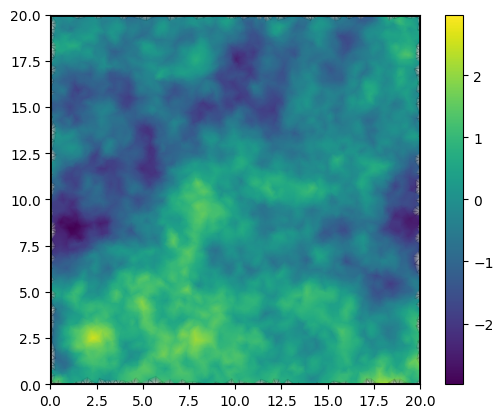

In [6]:
spde.gen_and_plot_realization()

## Generate data

In [ ]:
n_observations = 500
n_realizations = 10

In [ ]:
min_x = 0
max_x = 20
min_y = 0
max_y = 20
loc_domain = torch.tensor(
    [[min_x, min_y], [max_x, min_y], [max_x, max_y], [min_x, max_y], [min_x, min_y]]
)

# Create preiction values
X, Y = np.meshgrid(
    np.linspace(min_x, max_x, 100),
    np.linspace(min_y, max_y, 100),
)
locs_pred = np.vstack([X.ravel(), Y.ravel()]).T
A_pred = mesh.create_observation_matrix(locs_pred)

# Create observed values
locs_obs = np.random.uniform(
    low=[min_x, min_y],
    high=[max_x, max_y],
    size=(n_observations, 2),
)
A_obs = mesh.create_observation_matrix(locs_obs)
Y_full = spde.inference.simulate_field(N_sim=n_realizations, seed=None)
Y_obs = A_obs.to_dense() @ Y_full
Y_obs += np.random.normal(0, sigmae_val, Y_obs.shape)  # Add noise to observations
U_pred = A_pred.to_dense() @ Y_full


/var/folders/k0/c2t4yqdx6svbs1y_6ktzvsyc0000gn/T/ipykernel_17477/2263172670.py:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Y_obs = A_obs.to_dense() @ Y_full
/var/folders/k0/c2t4yqdx6svbs1y_6ktzvsyc0000gn/T/ipykernel_17477/2263172670.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Y_obs += np.random.normal(0, sigmae_val, Y_obs.shape) # Add noise to observations
/var/folders/k0/c2t4yqdx6svbs1y_6ktzvsyc0000gn/T/ipykernel_17477/2263172670.py:31: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  U_pred = A_pred.to_dense() @ Y_full


/var/folders/k0/c2t4yqdx6svbs1y_6ktzvsyc0000gn/T/ipykernel_17477/211765020.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  vmax = np.abs(Y_obs[:, 0]).max()


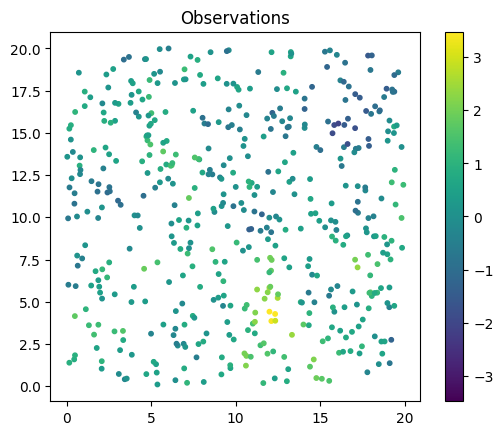

In [9]:
vmax = np.abs(Y_obs[:, 0]).max()
plt.scatter(locs_obs[:, 0], locs_obs[:, 1], c=Y_obs[:, 0], s=10, vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.gca().set_aspect("equal", adjustable="box")
plt.title("Observations")
plt.show()

## Estimate parameters using observations

In [ ]:
# Create the projection matrices for the observations and prediction locations
Y_test = U_pred
A_test = mesh.create_observation_matrix(locs_pred)
locs_train = locs_obs[:n_observations, :]
Y_train = Y_obs[:n_observations, :]
A_train = mesh.create_observation_matrix(locs_train)


/Users/ellingsvee/Documents/GitHub/MastersCode/spde/inference.py:294: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * (torch.log(torch.tensor(self.params.prior_anisotropy.get_bound())) ** 2)


- Iteration 1, loss: 912.1034060129142
-- nu: 0.596, sigmae: 0.705, theta_logkappa: [-1.174], theta_logsigma: [0.065]
-- theta_vx: [-0.146], theta_vy: [0.3]


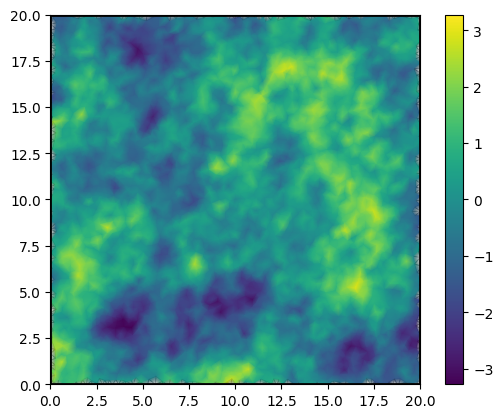

- Iteration 11, loss: -655.9193557439971
-- nu: 0.686, sigmae: 0.333, theta_logkappa: [-1.29], theta_logsigma: [-0.104]
-- theta_vx: [-0.004], theta_vy: [-0.136]


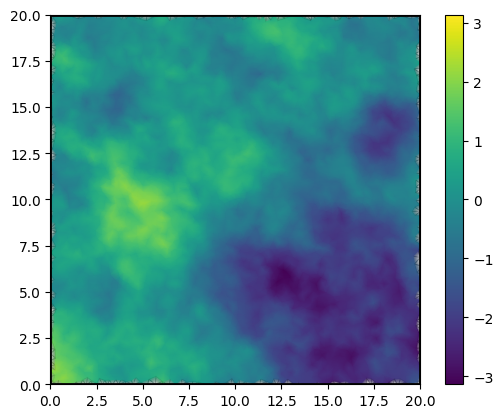

- Iteration 21, loss: -727.1554457818102
-- nu: 0.574, sigmae: 0.257, theta_logkappa: [-1.142], theta_logsigma: [-0.074]
-- theta_vx: [-0.081], theta_vy: [-0.076]


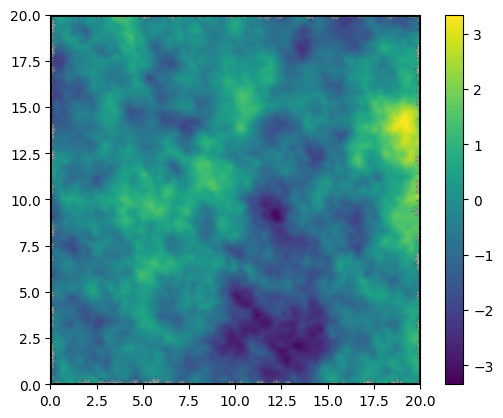

Stopping early: Relative loss change < 0.001 at iteration 29


In [ ]:
# Create random initial parameters with noise
initial_params_with_nosie = spde.params.get_logparam_list(
    rand_noise_amt=0.25,
    zero_val_rand_noise_amt=0.005,
    set_non_stat_params_to_zero=True,
    seed=None,
)

# Estimate the parameters using optimization
spde_opt, tot_iters = optimize_parameters(
    spde=spde,
    opt_params=initial_params_with_nosie,
    Y=Y_train,
    A=A_train,
    X=None,
    fixed_nu=False,
    fixed_nu_val=1.0,
    return_n_opt_steps=True,
    max_opt_iterations=80,
    use_stopping_criterion=True,
    ftol_rel=1e-3,
    gtol=None,
    lr=0.1,
    progress_update_step=10,
    plot_updates=True,
)


## Visualize results

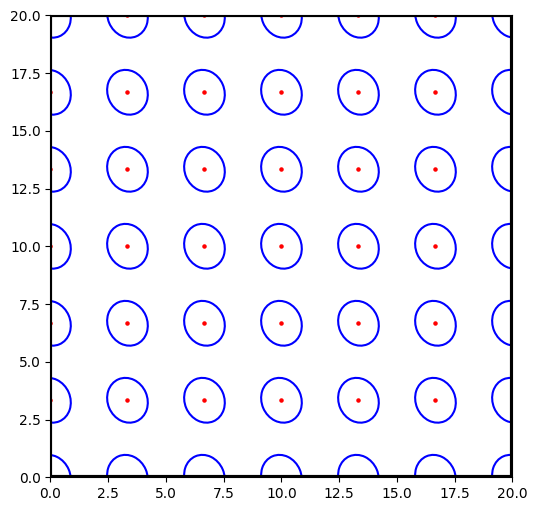

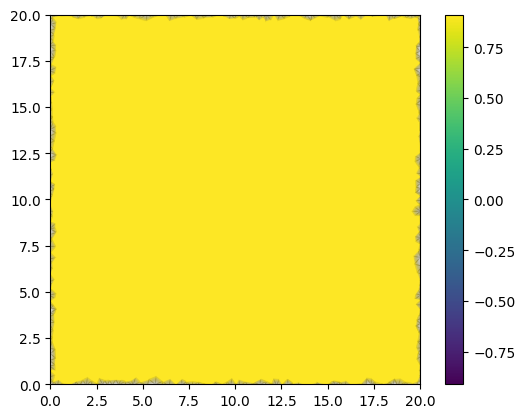

In [ ]:
# Iso correlation curves
spde_opt.utils.plot_iso_correlation(domain_padding=0, n_pts_x=7, n_pts_y=7)

# Marginal standard deviation
mesh.plot(
    spde.params.sigma.detach().numpy(),
    only_inside_loc_domain=True,
)


## Predict

In [ ]:
# The mean and variance at the prediction locations
MU_pred, VAR_pred = spde_opt.inference.predict(
    Y=Y_train,
    A=A_train,
    Apred=A_test,
    add_observation_noise=False,
)

# RMSE nd CRPS scores
rmse_val = rmse(Y_test, MU_pred).item()
crps_val = crps(Y_test, MU_pred, torch.sqrt(VAR_pred)).item()

MU_pred_with_noise, VAR_pred_with_noise = spde_opt.inference.predict(
    Y=Y_train,
    A=A_train,
    Apred=A_test,
    add_observation_noise=True,
)

# Coverage score
coverage_val = coverage(
    Y_test, MU_pred_with_noise, torch.sqrt(VAR_pred_with_noise)
).item()
print(f"RMSE: {rmse_val:.3f}, CRPS: {crps_val:.3f}, Coverage: {coverage_val:.3f}")

/Users/ellingsvee/Documents/GitHub/MastersCode/utils/scores.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pdf = torch.exp(-0.5 * Z**2) / torch.sqrt(torch.tensor(2 * torch.tensor(torch.pi)))


RMSE: 0.326, CRPS: 0.180, Coverage: 0.994
